In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import matplotlib.ticker as mtick
import os
plt.style.use('ggplot')

In [15]:
data = pd.read_csv(r'C:\Users\33783\Desktop\Python AI projetcs\Untitled Folder\sentiment_data.csv')

data['date'] = pd.to_datetime(data['date'])

data = data.set_index(['date','symbol'])

data['engagement_ratio'] = data['twitterComments']/data['twitterLikes']

data = data[(data['twitterComments'] > 10) & (data['twitterLikes'] > 20)]

data

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

# Aggregate monthly and compute average sentiment for the month
 - then choose the 5 best stocks

In [22]:
aggregated_df = data.reset_index('symbol').groupby([pd.Grouper(freq = 'M'), 'symbol'])[['engagement_ratio']].mean()

aggregated_df['rank'] = aggregated_df.groupby(level=0)['engagement_ratio'].transform(lambda x: x.rank(ascending = False))

aggregated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

# Select top 5 stocks ranked by engagement_ratio

In [38]:
# filtered_df = aggregated_df[aggregated_df['rank']<6].copy()

# filtered_df = filtered_df.reset_index(level = 1)

# filtered_df.index = filtered_df.index + pd.DateOffset(1)

# # now we have the stocks we want to invest in for the next month

# filtered_df = filtered_df.reset_index().set_index(['date','symbol'])

filtered_df

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
...                             ...   ...
2023-02-01 A               0.471572   5.0
           AES             0.533809   4.0
           BIIB            0.839303   1.0
           FCX             0.667387   3.0
           MDT             0.806841   2.0

[75 rows x 2 columns]

# Extract the stocks and create proftolio of each new month

In [44]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

# Download fresh prices for only selected stocks

In [47]:
stocks_list = data.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers = stocks_list,
                       start = '2021-01-01',
                       end = '2023-03-01')


[*********************100%***********************]  85 of 85 completed


# Calculate portfolio returns with monthly rebalancing

In [58]:
# returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    stocks = fixed_dates[start_date]
    
    # now we calculate the equally weighted returns on our portfolio for everyday
    temp_df = returns_df[start_date:end_date][stocks].mean(axis = 1).to_frame('portfolio_return')
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis = 0)
    
portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


# Download Nasdaq/QQQ and compare returns

In [60]:
qqq_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,315.109985,315.290009,305.179993,309.309998,304.244354,45305900
2021-01-05,308.290009,312.140015,308.290009,311.859985,306.752625,29323400
2021-01-06,307.000000,311.880005,305.980011,307.540009,302.503326,52809600
2021-01-07,310.279999,315.839996,310.250000,314.980011,309.821472,30394800
2021-01-08,317.339996,319.390015,315.079987,319.029999,313.805206,33955800
...,...,...,...,...,...,...
2023-02-22,294.619995,296.359985,292.559998,294.250000,292.968658,51389200
2023-02-23,297.970001,298.130005,292.549988,296.820007,295.527466,69294400
2023-02-24,291.760010,292.970001,290.049988,291.850006,290.579071,74332000


In [61]:
qqq_df = yf.download(tickers = 'QQQ',
                     start = '2021-01-01',
                     end = '2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


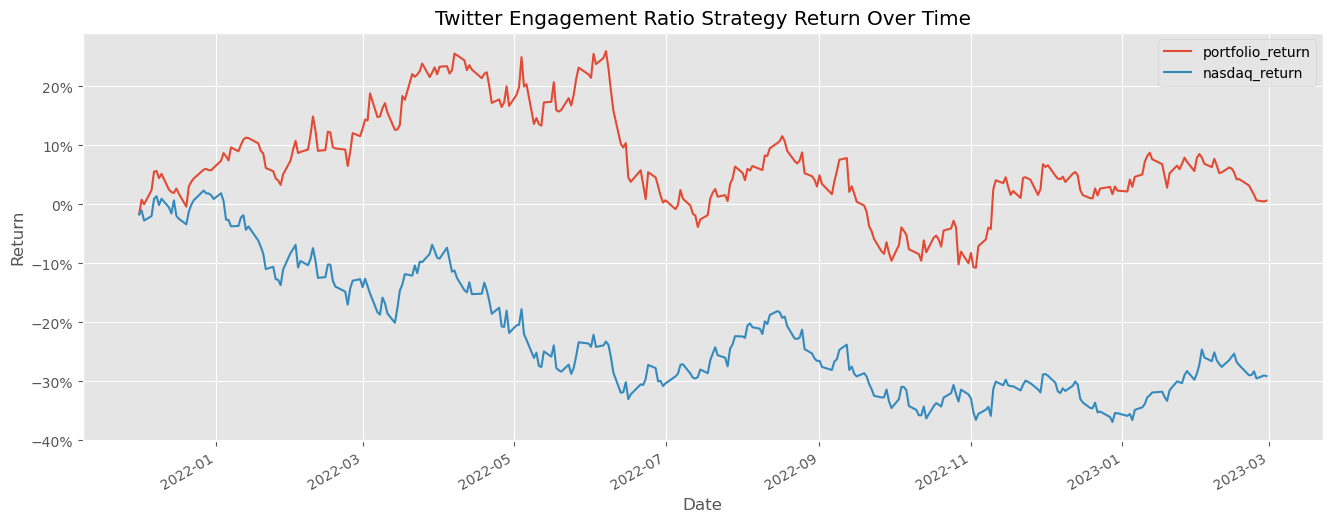

In [66]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()